# Human Variation and Diesase Coalescent Computer Lab
---

Welcome to the coalescent computer lab! Here we'll explore some fundamentals of the coalescent using exploratory data analysis (i.e. computing summary statistics / visualization) and simulation. We'll learn about & employ a powerful coalescent simulator called `msprime`, which allows us to efficiently generate genealogies under a given demography and subsequently sprinkle mutations on these genealogies to generate sequence data. Coalescent simulation is a very important tool to be equipped with for the modern population geneticist for a number of reasons...

* It allows us to develop intuition for a simple generative model that can help to explain patterns in real data
* We can use simulations to compare the accuracy of methods and see where they break down or succeed
* Simulation can be used in inference, for instance to obtain monte carlo estimates for particular steps of a intractable model or perform approximate Bayesian inference (ABC)

A quick note about computing: The environment we are in is called a `jupyter notebook`. A `jupyter notebook` is an interactive computational portal that allows us to make documents that combine simple text formats (markdown / latex) and code. This is quite powerful as we can write up analyses and explorations in the notebook and annotate visualizations & code with text and even math. Jupyter is primarily geared for `python` but one can actually change the "kernel" of the notebook to use `R` and even `julia`. Today we'll actually be using a very interesting python package called `rpy2` which allows us to run `R` commands in a `python` “kernel”. We can even pass objects created in python into an `R` code block. How this works will become more clear as we get started. 

Alright, now let us begin by importing various libraries that we'll be using in this notebook!

## Imports / Configuration

Here we load a jupyter extension that allows us to use `rpy2` to pass objects back and forth between `R` and `python` code blocks. 

In [ ]:
%load_ext rpy2.ipython

This is how we import packages in python. `numpy` is a python package for creating, manipulating and operating on arrays. As we mentioned previously, `msprime` is a python package for performing coalescent simulations. It expands upon [Dick Hudson's](http://home.uchicago.edu/rhudson1/), a UChicago professor and coalescent pioneer, `ms` software. 

In [1]:
import numpy as np
import msprime 

Here is a quick example of how we can pass python objects into `R`. Lets first create a simple matrix $\mathbf{A}$ 

In [ ]:
A = np.array([[1,2], [3, 4]])
A

Lets now import $\mathbf{A}$ into `R`. To use `R` run the `%%R` command in the top of the code block ...

In [ ]:
%%R -i A
A

Cool! That seems to work. Lets try making simple plot ...

In [ ]:
%%R
library(ggplot2)
qplot(rnorm(1000))

We are now equipped to run the rest of the notebook ...

## A "fishy" population genetics mystery

Suppose you are hired as a consultant for the local fisheries agency. They have decided they'd like to track the genetic diversity of the *strange and quite rare* haploid salmon population to help inform conservation efforts on this important species. They give ***you*** a genomic dataset that was generated from $n=50$ individuals in $r=100$ independent non-recombining regions of the salmon genome each of length $\ell=5000 \ bp$. The  dataset they give you is a genotype matrix where the rows represent each haploid individual and the columns represent different genetic variants.

In [ ]:
G = np.load("../data/genotype_matrix.npy")
G

---

In `python` or `R` (*your choice*) visualize the genotype matrix and write four functions that take in `G` as an argument to compute some classic coalescent summary statistics ...

* visualize the genotype matrix
* nucleotide diversity $\pi$
* the number of segregating sites $S$
* the site frequency spectrum $(\zeta_1, \zeta_2, \dots, \zeta_n)$ 

In [ ]:
%%R -i G
# R code goes here

In [ ]:
# python code goes here

Given your estimate of $\pi$ and $S$ compute Tajima's $D$ and plot the SFS ...

In [ ]:
%%R
# R code for computations and plots go here

In [ ]:
# python code for computations and plots go here

What do these tell you about the salmon population demographics (specifically the population size)?

---

Now that you have some preliminary summaries of the data you decide you want to gain some more insight into the demographic history of the salmon population. The coalescent provides us with a powerful link between demographic history and the observed genetic data. Let’s take some time to learn about `msprime` to make this link more clear ...

## Coalescent simulation using `msprime`

msprime is a widely used software for runnning coalescent simulations. There is a nice tutorial located here (https://msprime.readthedocs.io/en/stable/tutorial.html). This is a really nice [jupyter notebook](https://github.com/jhmarcus/spg-chapter/) written by [Jerome Kelleher](https://github.com/jeromekelleher), the author of `msprime`. Click the launch binder button at the bottom of the page. We strongly encourage you to change parameters in the notebook and build intuition on how that affects properties of coalescent trees and see how it matches your predictions from the theory we've learned in class.

## Writing your own coalescent simulations

Let's start by running our first simulation! To do this we will use the function msprime.simulate(), passing in the sample size and effective population size $N_e$ as arguments. Since we haven't provided a recombination rate, we are only simulating a single coalescent tree.  

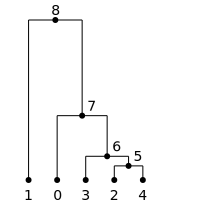

In [18]:
tree_sequence = msprime.simulate(sample_size=5, Ne=1000)
tree = tree_sequence.first()
SVG(tree.draw())

Now that we have simulated a coalescent tree, we might want to learn some properties of it. For example, let's find the $T_{MRCA}$ for our tree. 

In [9]:
T_mrca = tree.time(tree.root)
T_mrca

4316.742968949674

However, this is just one simulation. Let's run 1,000 simulations and find the average $T_{MRCA}$.

In [12]:
num_reps = 1000
T_mrca = np.zeros(num_reps)
for j, ts in enumerate(msprime.simulate(sample_size=5, Ne=1000,num_replicates=num_reps)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca)

3188.89868751037

**Question 1** Compare the result above to our theoretical expectation for $T_{MRCA}$ for $n=5$ and $N_e = 1000$. Then re-run the simulation for $N_e = 10000$, do you expect the average $T_{MRCA}$ to increase or decrease, why? 

In [ ]:
%%R -i 
# your R code goes here

In [ ]:
# your python code goes here 

### Adding Recombination  

While simulating a single coalescent tree is useful, often times we are interested in a locus of a specific length under the influence of recombination. This whill create a series of coalescent trees over the length of our locus. In msprime we can use the same msprime.simulate function and add two arguments, length and recombination_rate. The length parameter is the number of base pairs and recombination rate is in units of per base per generation.   

In [28]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, recombination_rate=2e-8)
# Let's look at the trees we made and the intervals they occur over 
for tree in tree_sequence.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    print(tree.draw(format="unicode"))

--------------------
tree 0: interval = (0.0, 92.39768145894578)
   6     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 2 1 3  

--------------------
tree 1: interval = (92.39768145894578, 1224.7783903090233)
   8     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 2 1 3  

--------------------
tree 2: interval = (1224.7783903090233, 8239.91810861973)
   7     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 2 1 3  

--------------------
tree 3: interval = (8239.91810861973, 10000.0)
   8     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 2 1 3  



### Adding mutation

So far we have simulated a region of chromosome with recombination, now want to put mutations down onto our sequence of coalescent trees. Mutations are generated in msprime by throwing mutations down on the branches of trees at a particular rate. The mutations are generated under the infinite sites model, and so each mutation occurs at a unique (floating point) point position along the genomic interval occupied by a tree. The mutation rate for simulations is specified using the mutation_rate parameter of simulate(). Below we will simulate 50kb or non-recombiing chromosome and add mutations onto the coalescent tree.

Mutation @ position 1239.40 over node 13
Mutation @ position 8842.09 over node 13
Mutation @ position 11759.03 over node 11
Mutation @ position 15806.67 over node 2
Mutation @ position 16177.68 over node 13
Mutation @ position 16762.10 over node 2
Mutation @ position 17312.52 over node 2
Mutation @ position 18349.37 over node 12
Mutation @ position 29771.91 over node 2
Mutation @ position 34897.51 over node 17
Mutation @ position 41735.75 over node 12
Mutation @ position 46566.56 over node 10
Mutation @ position 49697.99 over node 14


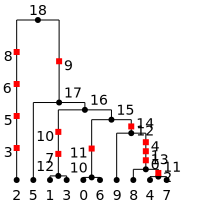

In [35]:
tree_sequence = msprime.simulate(
    sample_size=10, Ne=1000, length=50e3, mutation_rate=2e-8, random_seed=30)
tree = tree_sequence.first()
for site in tree.sites():
     for mutation in site.mutations:
            print("Mutation @ position {:.2f} over node {}".format(
                site.position, mutation.node))
SVG(tree.draw())

From here we can create a genotype matrix for our samples 

In [36]:
G = tree_sequence.genotype_matrix()
G

array([[0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 1]], dtype=uint8)

In the genotype matrix each individual is a separate column and each mutation is a row. If we look at individual 2, we see that the should have a "1" indicating that they have the mutation for mutations 2, 5, 6, and 8. 

**Question 2** Write a function to calculate the number of segregating sites in the sample

In [ ]:
%%R -i G
# R code goes here

In [ ]:
# python code goes here 

**Question 3** Write a function to calculate nucleotide diversity in the sample

In [ ]:
%%R -i G
# R code goes here

In [ ]:
# python code goes here 

**Question 4** Plot the site frequency spectrum for this sample 

In [ ]:
%%R -i G
# R code goes here

In [ ]:
# python code goes here 

# Simulating under human demographic models using stdpopsim

For those that finish early, continue reading the rest of the [simulation](https://github.com/jhmarcus/spg-chapter/)  tutorial to learn how to simulate genetic data under more complicated demographic histories and the coalescent with recombination. Also check out the [inference example](https://github.com/jhmarcus/spg-chapter/blob/master/jupyter/inference-example.ipynb) in the statistical genetics chapter.